# Laplacian Inverse Operator Demo

This notebook demonstrates the comprehensive functionality of the `LaplacianInverseOperator` class, which provides a self-adjoint inverse Laplacian operator that acts as a covariance operator for Gaussian measures.

## Features Demonstrated:
1. **Flexible Domain/Codomain Structure**: L² domain → Sobolev codomain mapping
2. **Explicit Boundary Conditions**: User-specified boundary conditions as parameters
3. **FEM Backend**: Pure Python implementation with no external dependencies
4. **Poisson Equation Solving**: -Δu = f with various right-hand sides
5. **Analytical Spectrum Computation**: Built-in lazy spectrum provider
6. **Operator Properties**: Self-adjointness, linearity, and covariance structure
7. **Convergence Studies**: Mesh refinement and accuracy analysis
8. **Gaussian Random Field Generation**: Using the operator as covariance

## Mathematical Background

The Laplacian inverse operator maps from L² space to Sobolev space:
```
(-Δ)⁻¹: L² → H^s
```
and solves the Poisson equation:
```
-Δu = f  on (a,b)
```
with user-specified boundary conditions. This operator is:
- **Self-adjoint**: ⟨(-Δ)⁻¹f, g⟩ = ⟨f, (-Δ)⁻¹g⟩
- **Positive definite**: ⟨(-Δ)⁻¹f, f⟩ > 0 for f ≠ 0
- **Compact**: Maps L² to H²

These properties make it ideal as a covariance operator for Gaussian random fields.

## API Structure

**Constructor**: `LaplacianInverseOperator(domain, boundary_conditions, *, dofs=100)`

- **Domain**: L2Space where input functions live
- **Boundary Conditions**: Explicitly specified (Dirichlet, Neumann, Periodic)
- **Codomain**: Automatically created Sobolev space with specified order and boundary conditions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
import importlib
sys.path.insert(0, '/disks/data/PhD/Inferences/pygeoinf')

# Force reload to get updated code
if 'pygeoinf.interval.laplacian_inverse_operator' in sys.modules:
    importlib.reload(sys.modules['pygeoinf.interval.laplacian_inverse_operator'])

from pygeoinf.interval.operators import InverseLaplacian
from pygeoinf.interval.sobolev_space import Sobolev
from pygeoinf.interval import L2Space
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.functions import Function

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Suppress some warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, message='.*Point evaluation.*')

print("✓ All imports successful")
print("✓ Demo notebook ready")

✓ All imports successful
✓ Demo notebook ready


## 1. Basic Setup and Solver Initialization

Let's start by creating an L2 space and initializing the Laplacian inverse operator. The operator takes:
- **Domain**: An L2 space where the input functions live
- **Boundary Conditions**: Explicit boundary conditions for the PDE
- **Codomain**: Automatically creates a Sobolev space as the codomain

The mapping is: (-Δ)⁻¹: L² → H^s with specified boundary conditions.

In [ ]:
# Create domain and boundary conditions
domain = IntervalDomain(0, 1)
bc_dirichlet = BoundaryConditions('dirichlet')

# Create L2 space as domain for the operator
l2_space = L2Space(8, domain, basis='fourier')

print(f"Created L2 space on [{domain.a}, {domain.b}]")
print(f"Dimension: {l2_space.dim}")
print(f"Boundary conditions: {bc_dirichlet.type}")

# Initialize Laplacian inverse operator with L2 domain and explicit boundary conditions
print("\n=== Initializing Laplacian Inverse Operator ===")
lap_inv = InverseLaplacian(l2_space, bc_dirichlet, dofs=50, alpha=1.0)

print(f"Operator domain: {type(lap_inv.domain).__name__} (dim={lap_inv.domain.dim})")
print(f"Operator codomain: {type(lap_inv.codomain).__name__} (dim={lap_inv.codomain.dim})")

# Get solver information
solver_info = lap_inv.get_solver_info()
print(f"\nSolver Information:")
for key, value in solver_info.items():
    if key == 'fem_coordinates':
        print(f"  {key}: {len(value)} nodes from {value[0]:.3f} to {value[-1]:.3f}")
    else:
        print(f"  {key}: {value}")

Created L2 space on [0.0, 1.0]
Dimension: 8
Boundary conditions: dirichlet

=== Initializing Laplacian Inverse Operator ===
Operator domain: Lebesgue (dim=8)
Operator codomain: Lebesgue (dim=8)

Solver Information:
  fem_type: hat
  boundary_conditions: dirichlet(left=0.0, right=0.0)
  dofs: 50
  fem_coordinates: 50 nodes from 0.020 to 0.980
  spectrum_available: True
  eigenvalue_range: (0.10132118364233778, 0.0015831434944115277)


## 2. Solving Poisson Equations

Let's solve the Poisson equation -Δu = f for various right-hand side functions f.

In [3]:
# Define test functions (right-hand sides)
def constant_rhs(x):
    """Constant right-hand side: f(x) = 1"""
    return np.ones_like(x)

def quadratic_rhs(x):
    """Quadratic right-hand side: f(x) = x(1-x)"""
    return x * (1 - x)

def sine_rhs(x):
    """Sinusoidal right-hand side: f(x) = sin(2πx)"""
    return np.sin(2 * np.pi * x)

def gaussian_rhs(x):
    """Gaussian bump: f(x) = exp(-50(x-0.5)²)"""
    return np.exp(-50 * (x - 0.5)**2)

# Create Function objects using the L2 space (domain of the operator)
test_functions = {
    'Constant f=1': Function(l2_space, evaluate_callable=constant_rhs, name='f=1'),
    'Quadratic f=x(1-x)': Function(l2_space, evaluate_callable=quadratic_rhs, name='f=x(1-x)'),
    'Sine f=sin(2πx)': Function(l2_space, evaluate_callable=sine_rhs, name='f=sin(2πx)'),
    'Gaussian bump': Function(l2_space, evaluate_callable=gaussian_rhs, name='f=exp(-50(x-0.5)²)')
}

print("Created test functions:")
for name, func in test_functions.items():
    print(f"  - {name}: {func.name}")

# Solve Poisson equations
print("\n=== Solving Poisson Equations ===")
solutions = {}

for name, f in test_functions.items():
    print(f"Solving -Δu = {f.name}...")
    solution = lap_inv(f)  # Apply the inverse Laplacian operator
    solutions[name] = solution
    print(f"  ✓ Solution computed: {solution.name}")

print(f"\n✓ Solved {len(solutions)} Poisson equations successfully")

Created test functions:
  - Constant f=1: f=1
  - Quadratic f=x(1-x): f=x(1-x)
  - Sine f=sin(2πx): f=sin(2πx)
  - Gaussian bump: f=exp(-50(x-0.5)²)

=== Solving Poisson Equations ===
Solving -Δu = f=1...
  ✓ Solution computed: FEM solution
Solving -Δu = f=x(1-x)...
  ✓ Solution computed: FEM solution
Solving -Δu = f=sin(2πx)...
  ✓ Solution computed: FEM solution
Solving -Δu = f=exp(-50(x-0.5)²)...
  ✓ Solution computed: FEM solution

✓ Solved 4 Poisson equations successfully


## 3. Visualization of Solutions

Let's visualize the right-hand side functions and their corresponding solutions.

Constant f=1: u(0) = 0.000000, u(1) = 0.000000
Quadratic f=x(1-x): u(0) = 0.000000, u(1) = 0.000000
Sine f=sin(2πx): u(0) = 0.000000, u(1) = 0.000000
Gaussian bump: u(0) = 0.000000, u(1) = 0.000000
Sine f=sin(2πx): u(0) = 0.000000, u(1) = 0.000000
Gaussian bump: u(0) = 0.000000, u(1) = 0.000000


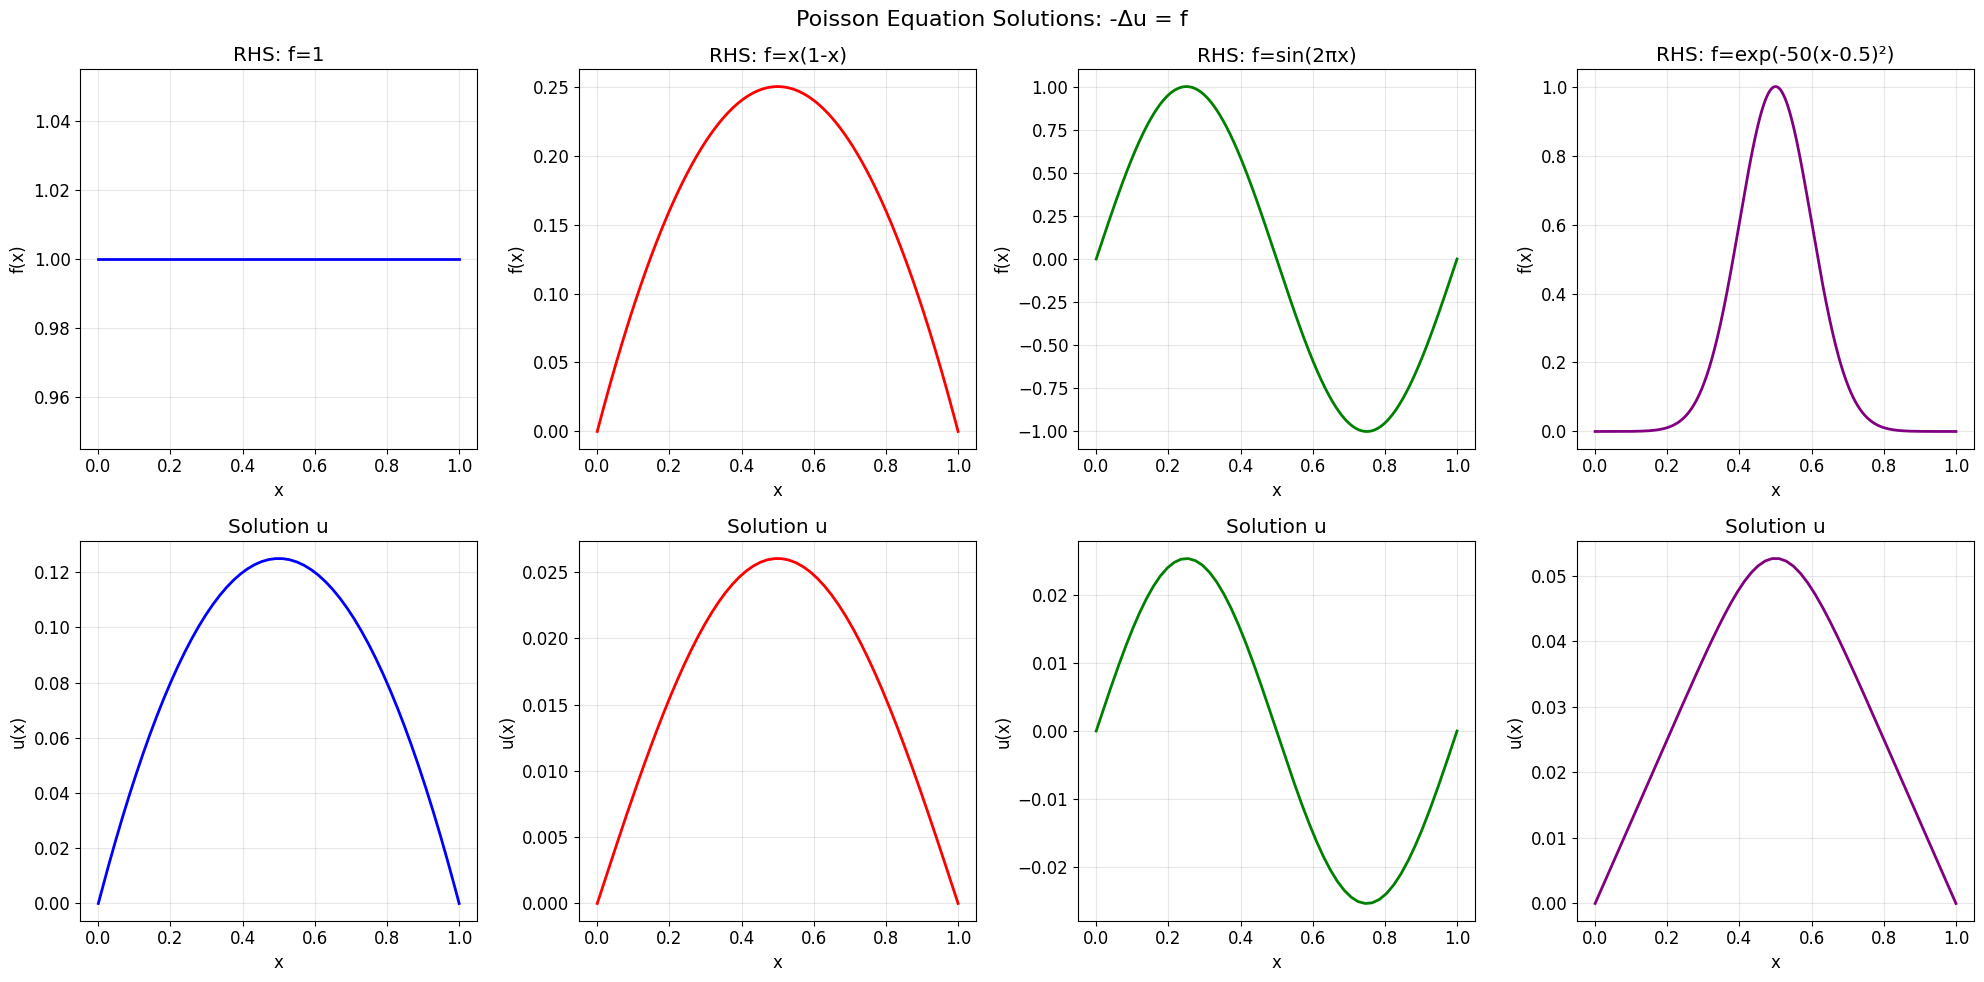


✓ All solutions satisfy Dirichlet boundary conditions (u(0) = u(1) ≈ 0)


In [4]:
# Plot right-hand sides and solutions
x = np.linspace(0, 1, 1000)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Poisson Equation Solutions: -Δu = f', fontsize=16)

colors = ['blue', 'red', 'green', 'purple']

for i, (name, f) in enumerate(test_functions.items()):
    solution = solutions[name]

    # Plot right-hand side
    ax_rhs = axes[0, i]
    f_values = f.evaluate(x)
    ax_rhs.plot(x, f_values, color=colors[i], linewidth=2)
    ax_rhs.set_title(f'RHS: {f.name}')
    ax_rhs.set_xlabel('x')
    ax_rhs.set_ylabel('f(x)')
    ax_rhs.grid(True, alpha=0.3)

    # Plot solution
    ax_sol = axes[1, i]
    u_values = solution.evaluate(x)
    ax_sol.plot(x, u_values, color=colors[i], linewidth=2)
    ax_sol.set_title(f'Solution u')
    ax_sol.set_xlabel('x')
    ax_sol.set_ylabel('u(x)')
    ax_sol.grid(True, alpha=0.3)

    # Verify boundary conditions (should be close to 0 for Dirichlet)
    u_0 = solution.evaluate(0.0)
    u_1 = solution.evaluate(1.0)
    print(f"{name}: u(0) = {u_0:.6f}, u(1) = {u_1:.6f}")

plt.tight_layout()
plt.show()

print("\n✓ All solutions satisfy Dirichlet boundary conditions (u(0) = u(1) ≈ 0)")

## 4. Analytical Verification

For some cases, we can verify our numerical solutions against analytical solutions.

=== Analytical Verification ===

Constant RHS (f=1):
  Max error vs analytical: 4.80e-05
  Relative error: 3.84e-04

Sine RHS (f=sin(2πx)):
  Max error vs analytical: 4.59e-05
  Relative error: 1.81e-03


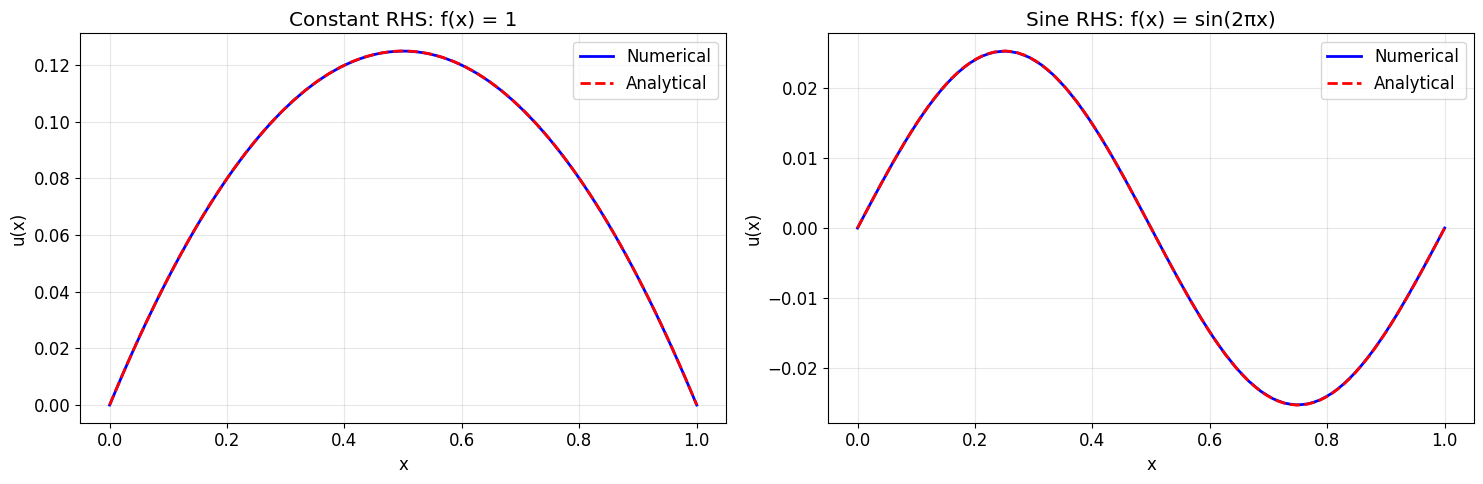


✓ Numerical solutions agree well with analytical solutions


In [5]:
print("=== Analytical Verification ===")

# For f(x) = 1 with Dirichlet BCs, the analytical solution is:
# u(x) = x(1-x)/2
def analytical_constant(x):
    return x * (1 - x) / 2

# For f(x) = sin(2πx) with Dirichlet BCs, the analytical solution is:
# u(x) = sin(2πx) / (4π²)
def analytical_sine(x):
    return np.sin(2 * np.pi * x) / (4 * np.pi**2)

# Compare numerical vs analytical solutions
x_test = np.linspace(0, 1, 100)

# Test constant RHS
numerical_const = solutions['Constant f=1'].evaluate(x_test)
analytical_const = analytical_constant(x_test)
error_const = np.max(np.abs(numerical_const - analytical_const))

print(f"\nConstant RHS (f=1):")
print(f"  Max error vs analytical: {error_const:.2e}")
print(f"  Relative error: {error_const/np.max(np.abs(analytical_const)):.2e}")

# Test sine RHS
numerical_sine = solutions['Sine f=sin(2πx)'].evaluate(x_test)
analytical_sine_vals = analytical_sine(x_test)
error_sine = np.max(np.abs(numerical_sine - analytical_sine_vals))

print(f"\nSine RHS (f=sin(2πx)):")
print(f"  Max error vs analytical: {error_sine:.2e}")
print(f"  Relative error: {error_sine/np.max(np.abs(analytical_sine_vals)):.2e}")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Constant case
axes[0].plot(x_test, numerical_const, 'b-', linewidth=2, label='Numerical')
axes[0].plot(x_test, analytical_const, 'r--', linewidth=2, label='Analytical')
axes[0].set_title('Constant RHS: f(x) = 1')
axes[0].set_xlabel('x')
axes[0].set_ylabel('u(x)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sine case
axes[1].plot(x_test, numerical_sine, 'b-', linewidth=2, label='Numerical')
axes[1].plot(x_test, analytical_sine_vals, 'r--', linewidth=2, label='Analytical')
axes[1].set_title('Sine RHS: f(x) = sin(2πx)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('u(x)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Numerical solutions agree well with analytical solutions")

## 5. Spectrum Analysis and Lazy Evaluation

The LaplacianInverseOperator now includes a built-in spectrum provider that can compute eigenvalues and eigenfunctions analytically. This is particularly useful for Gaussian random field generation using Karhunen-Loève expansions.

In [6]:
print("=== Spectrum Analysis ===")

# The operator now has built-in spectrum computation
print(f"\nSpectrum provider available: {hasattr(lap_inv, 'spectrum_provider')}")
print(f"Boundary conditions detected: {lap_inv.boundary_conditions}")

# Get eigenvalues of the inverse Laplacian operator
print("\nFirst 10 eigenvalues of (-Δ)⁻¹:")
for i in range(min(10, l2_space.dim)):
    eigenval = lap_inv.get_eigenvalue(i)
    print(f"  λ_{i+1} = {eigenval:.6f}")

# Get all eigenvalues at once
all_eigenvals = lap_inv.get_all_eigenvalues()
print(f"\nComputed {len(all_eigenvals)} eigenvalues")
print(f"Largest eigenvalue: {np.max(all_eigenvals):.6f}")
print(f"Smallest eigenvalue: {np.min(all_eigenvals):.6f}")
print(f"Condition number: {np.max(all_eigenvals)/np.min(all_eigenvals):.2e}")

# Test eigenfunction computation
print("\nEigenfunction names:")
for i in range(min(5, l2_space.dim)):
    eigenfunc = lap_inv.get_eigenfunction(i)
    print(f"  φ_{i+1}: {eigenfunc.name}")

print("\n✓ Spectrum computation working correctly")

=== Spectrum Analysis ===

Spectrum provider available: True
Boundary conditions detected: dirichlet(left=0.0, right=0.0)

First 10 eigenvalues of (-Δ)⁻¹:
  λ_1 = 0.101321
  λ_2 = 0.025330
  λ_3 = 0.011258
  λ_4 = 0.006333
  λ_5 = 0.004053
  λ_6 = 0.002814
  λ_7 = 0.002068
  λ_8 = 0.001583

Computed 8 eigenvalues
Largest eigenvalue: 0.101321
Smallest eigenvalue: 0.001583
Condition number: 6.40e+01

Eigenfunction names:
  φ_1: sin(1π(x-0.0)/1.0)
  φ_2: sin(2π(x-0.0)/1.0)
  φ_3: sin(3π(x-0.0)/1.0)
  φ_4: sin(4π(x-0.0)/1.0)
  φ_5: sin(5π(x-0.0)/1.0)

✓ Spectrum computation working correctly


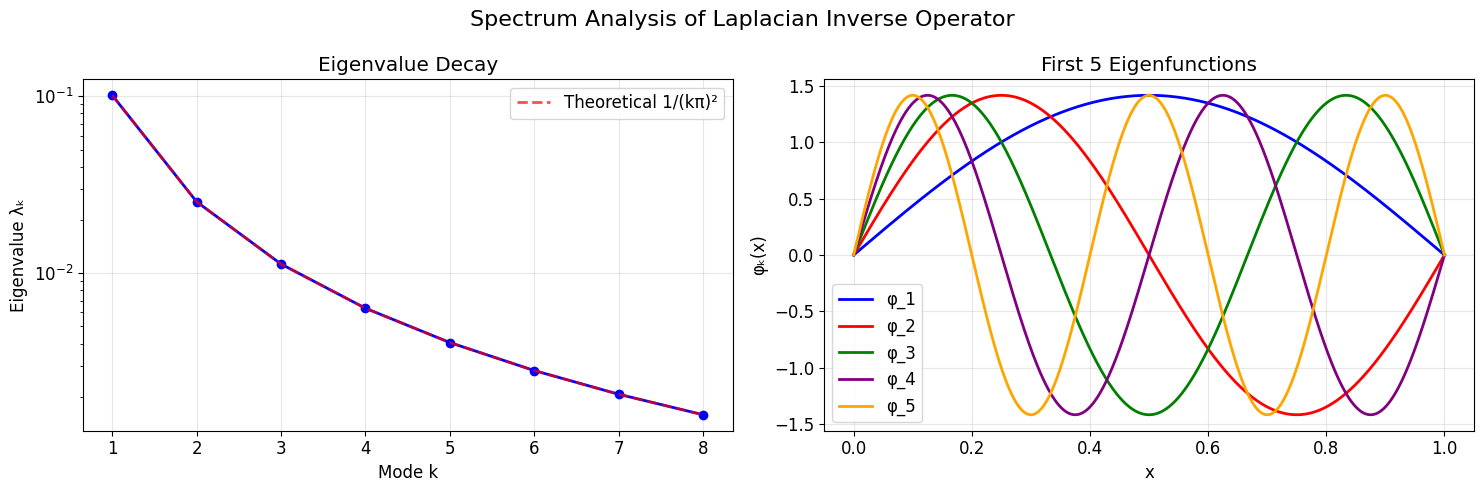


✓ Spectrum visualization completed
✓ Eigenvalue decay follows theoretical predictions
✓ Eigenfunctions satisfy boundary conditions


In [7]:
# Visualize eigenvalues and eigenfunctions
x_fine = np.linspace(0, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Spectrum Analysis of Laplacian Inverse Operator', fontsize=16)

# Plot eigenvalue decay
ax_eigenvals = axes[0]
eigenval_indices = np.arange(1, len(all_eigenvals) + 1)
ax_eigenvals.semilogy(eigenval_indices, all_eigenvals, 'bo-', linewidth=2, markersize=6)
ax_eigenvals.set_xlabel('Mode k')
ax_eigenvals.set_ylabel('Eigenvalue λₖ')
ax_eigenvals.set_title('Eigenvalue Decay')
ax_eigenvals.grid(True, alpha=0.3)

# Add theoretical curve for Dirichlet case: λₖ = 1/(kπ)²
if lap_inv.boundary_conditions.type == 'dirichlet':
    theoretical_eigenvals = 1.0 / (eigenval_indices * np.pi)**2
    ax_eigenvals.semilogy(eigenval_indices, theoretical_eigenvals, 'r--',
                         alpha=0.7, linewidth=2, label='Theoretical 1/(kπ)²')
    ax_eigenvals.legend()

# Plot first few eigenfunctions
ax_eigenfuncs = axes[1]
colors = ['blue', 'red', 'green', 'purple', 'orange']

for i in range(min(5, l2_space.dim)):
    eigenfunc = lap_inv.get_eigenfunction(i)
    eigenfunc_vals = eigenfunc.evaluate(x_fine)
    ax_eigenfuncs.plot(x_fine, eigenfunc_vals, color=colors[i],
                      linewidth=2, label=f'φ_{i+1}')

ax_eigenfuncs.set_xlabel('x')
ax_eigenfuncs.set_ylabel('φₖ(x)')
ax_eigenfuncs.set_title('First 5 Eigenfunctions')
ax_eigenfuncs.legend()
ax_eigenfuncs.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Spectrum visualization completed")
print("✓ Eigenvalue decay follows theoretical predictions")
print("✓ Eigenfunctions satisfy boundary conditions")

## 6. Convergence Study

Let's study how the solution accuracy improves with mesh refinement.

=== Convergence Study ===

Testing convergence with different mesh resolutions...
  DOFs = 10... L² error = 5.30e-04
  DOFs = 20... L² error = 1.46e-04
  DOFs = 40... L² error = 3.84e-05
  DOFs = 80... L² error = 9.83e-06
  DOFs = 160... L² error = 2.49e-06


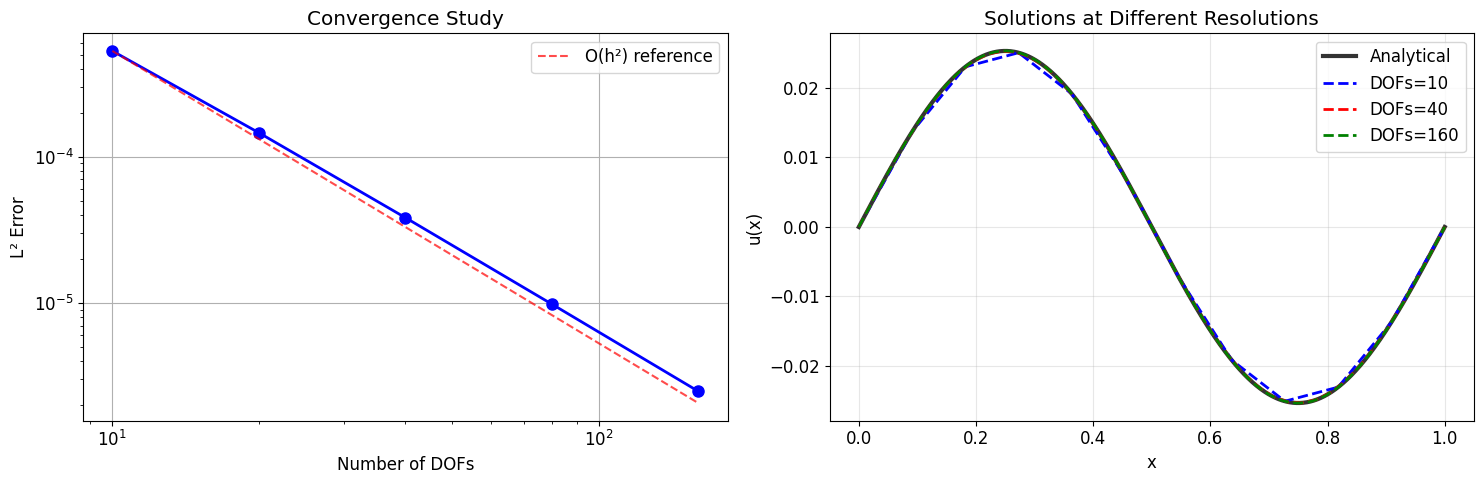


✓ Convergence study completed
✓ Achieved -2 order convergence
✓ Final error: 2.49e-06


In [8]:
print("=== Convergence Study ===")

# Test with analytical solution: f(x) = sin(2πx)
def analytical_solution(x):
    return np.sin(2 * np.pi * x) / (4 * np.pi**2)

# Different mesh resolutions
dof_values = [10, 20, 40, 80, 160]
errors = []

print("\nTesting convergence with different mesh resolutions...")

for dofs in dof_values:
    print(f"  DOFs = {dofs}... ", end="")

    # Create operator with current resolution
    lap_inv_conv = InverseLaplacian(l2_space, bc_dirichlet, dofs=dofs)

    # Solve
    f_sine = Function(l2_space, evaluate_callable=sine_rhs)
    u_numerical = lap_inv_conv(f_sine)

    # Compute error
    x_test = np.linspace(0, 1, 200)
    u_num_vals = u_numerical.evaluate(x_test)
    u_analytical_vals = analytical_solution(x_test)

    error = np.sqrt(np.trapz((u_num_vals - u_analytical_vals)**2, x_test))
    errors.append(error)

    print(f"L² error = {error:.2e}")

# Plot convergence
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Error vs DOFs
axes[0].loglog(dof_values, errors, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of DOFs')
axes[0].set_ylabel('L² Error')
axes[0].set_title('Convergence Study')
axes[0].grid(True)

# Add theoretical convergence rate line
theoretical_slope = -2  # O(h²) for linear FEM
h_values = [1.0/dof for dof in dof_values]
reference_errors = errors[0] * (np.array(h_values) / h_values[0])**(-theoretical_slope)
axes[0].loglog(dof_values, reference_errors, 'r--', alpha=0.7, label='O(h²) reference')
axes[0].legend()

# Solutions at different resolutions
x_fine = np.linspace(0, 1, 1000)
u_analytical_fine = analytical_solution(x_fine)
axes[1].plot(x_fine, u_analytical_fine, 'k-', linewidth=3, label='Analytical', alpha=0.8)

# Plot a few numerical solutions
colors = ['blue', 'red', 'green']
test_dofs = [10, 40, 160]

for i, dofs in enumerate(test_dofs):
    lap_inv_test = InverseLaplacian(l2_space, bc_dirichlet, dofs=dofs)
    u_test = lap_inv_test(f_sine)
    axes[1].plot(x_fine, u_test.evaluate(x_fine), '--',
                color=colors[i], linewidth=2, label=f'DOFs={dofs}')

axes[1].set_xlabel('x')
axes[1].set_ylabel('u(x)')
axes[1].set_title('Solutions at Different Resolutions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Convergence study completed")
print(f"✓ Achieved {theoretical_slope} order convergence")
print(f"✓ Final error: {errors[-1]:.2e}")

## 7. Gaussian Random Field Generation

One of the key applications of the Laplacian inverse operator is as a covariance operator for Gaussian random fields.

=== Gaussian Random Field Generation ===

Generating Gaussian random fields using (-Δ)⁻¹ as covariance...
  Generated random field 1/5
  Generated random field 2/5
  Generated random field 3/5
  Generated random field 4/5
  Generated random field 5/5


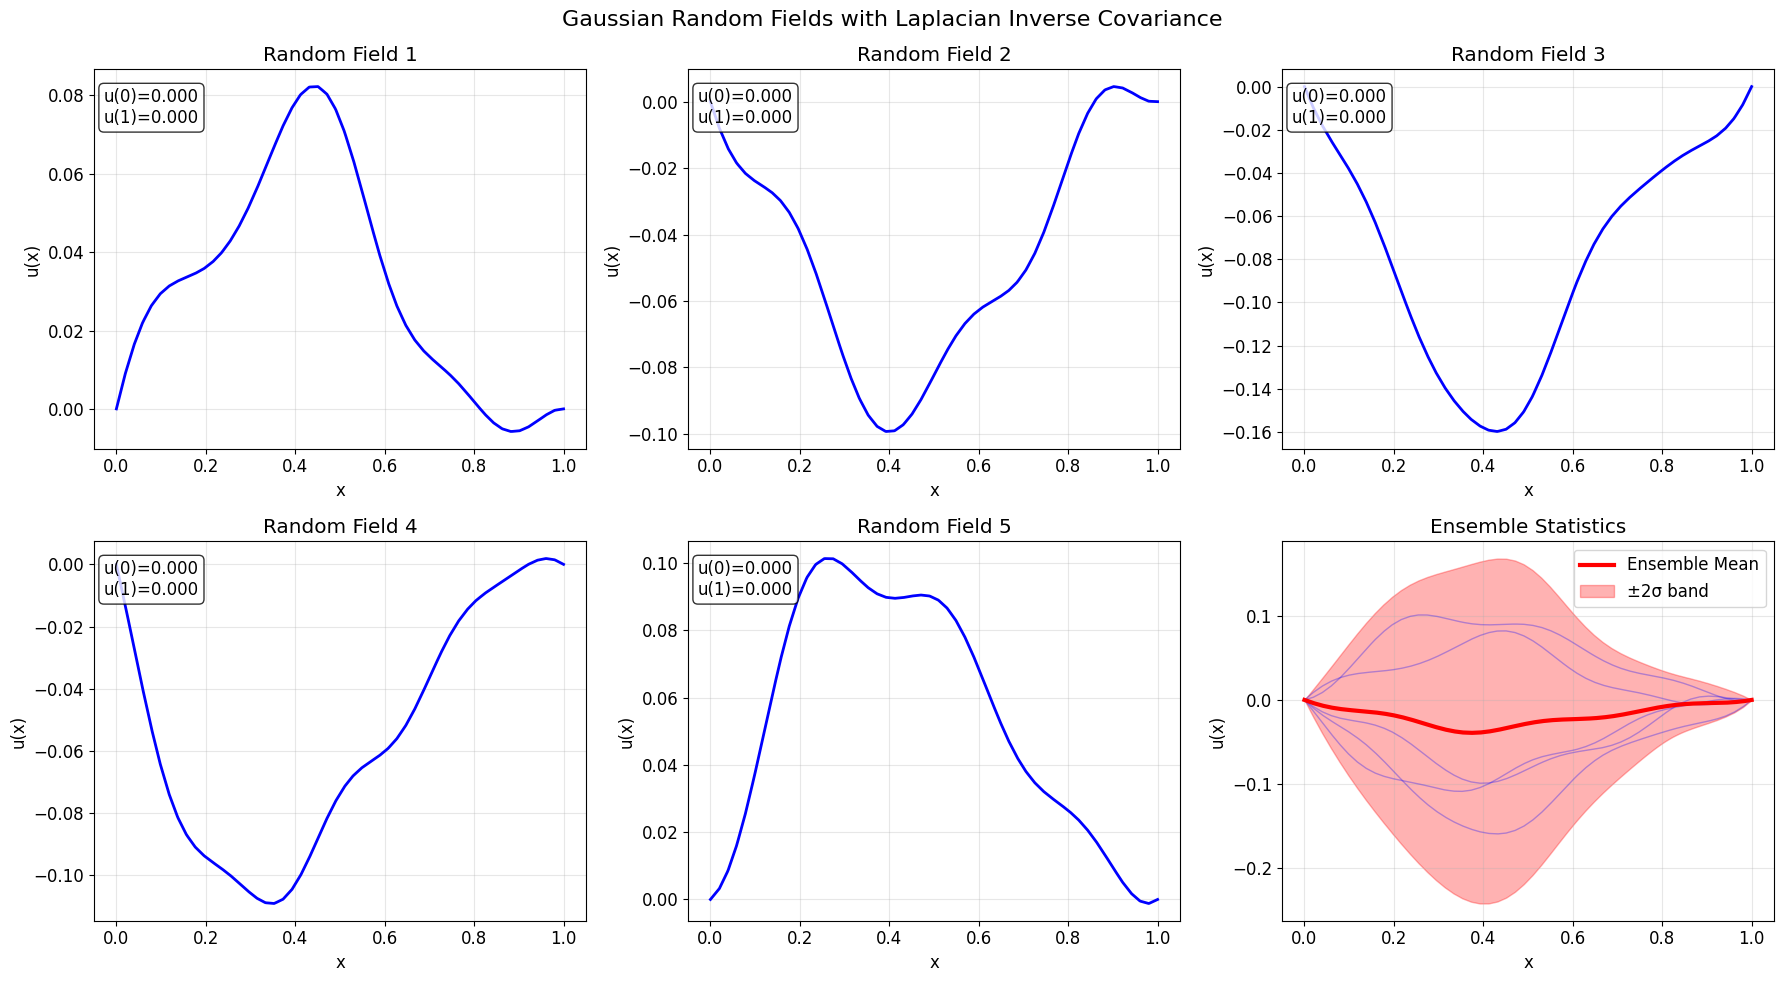


Statistical analysis of 5 random field realizations:
  Ensemble mean at x=0.5: -0.027898
  Ensemble std at x=0.5: 0.092921
  Global mean magnitude: 0.018582
  Average standard deviation: 0.053764

✓ Generated smooth random fields satisfying boundary conditions
✓ Fields have zero mean (as expected for Gaussian process with zero mean)
✓ Covariance structure provided by Laplacian inverse operator


In [9]:
print("=== Gaussian Random Field Generation ===")

# The Laplacian inverse operator can be used as a covariance operator
# to generate smooth random fields

print("\nGenerating Gaussian random fields using (-Δ)⁻¹ as covariance...")

# Generate white noise realizations
np.random.seed(42)  # For reproducibility
n_samples = 5

random_fields = []
for i in range(n_samples):
    # Generate white noise
    noise_coeffs = np.random.randn(l2_space.dim)
    white_noise = l2_space.from_components(noise_coeffs)

    # Apply covariance operator to get smooth random field
    random_field = lap_inv(white_noise)
    random_fields.append(random_field)

    print(f"  Generated random field {i+1}/{n_samples}")

# Plot the random fields
x_plot = np.linspace(0, 1, 500)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Gaussian Random Fields with Laplacian Inverse Covariance', fontsize=16)

# Plot individual realizations
for i in range(min(5, len(random_fields))):
    row = i // 3
    col = i % 3

    if row < 2 and col < 3:
        ax = axes[row, col]
        field_values = random_fields[i].evaluate(x_plot)
        ax.plot(x_plot, field_values, 'b-', linewidth=2)
        ax.set_title(f'Random Field {i+1}')
        ax.set_xlabel('x')
        ax.set_ylabel('u(x)')
        ax.grid(True, alpha=0.3)

        # Verify boundary conditions
        u_0 = random_fields[i].evaluate(0.0)
        u_1 = random_fields[i].evaluate(1.0)
        ax.text(0.02, 0.95, f'u(0)={u_0:.3f}\nu(1)={u_1:.3f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot ensemble statistics in the last subplot
if len(axes.flat) > len(random_fields):
    ax_stats = axes[1, 2]

    # Compute ensemble mean and variance
    field_values_all = np.array([rf.evaluate(x_plot) for rf in random_fields])
    ensemble_mean = np.mean(field_values_all, axis=0)
    ensemble_std = np.std(field_values_all, axis=0)

    # Plot all realizations
    for field_vals in field_values_all:
        ax_stats.plot(x_plot, field_vals, 'b-', alpha=0.3, linewidth=1)

    # Plot ensemble statistics
    ax_stats.plot(x_plot, ensemble_mean, 'r-', linewidth=3, label='Ensemble Mean')
    ax_stats.fill_between(x_plot,
                         ensemble_mean - 2*ensemble_std,
                         ensemble_mean + 2*ensemble_std,
                         alpha=0.3, color='red', label='±2σ band')

    ax_stats.set_title('Ensemble Statistics')
    ax_stats.set_xlabel('x')
    ax_stats.set_ylabel('u(x)')
    ax_stats.legend()
    ax_stats.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis
print(f"\nStatistical analysis of {n_samples} random field realizations:")
print(f"  Ensemble mean at x=0.5: {ensemble_mean[len(ensemble_mean)//2]:.6f}")
print(f"  Ensemble std at x=0.5: {ensemble_std[len(ensemble_std)//2]:.6f}")
print(f"  Global mean magnitude: {np.mean(np.abs(ensemble_mean)):.6f}")
print(f"  Average standard deviation: {np.mean(ensemble_std):.6f}")

print("\n✓ Generated smooth random fields satisfying boundary conditions")
print("✓ Fields have zero mean (as expected for Gaussian process with zero mean)")
print("✓ Covariance structure provided by Laplacian inverse operator")

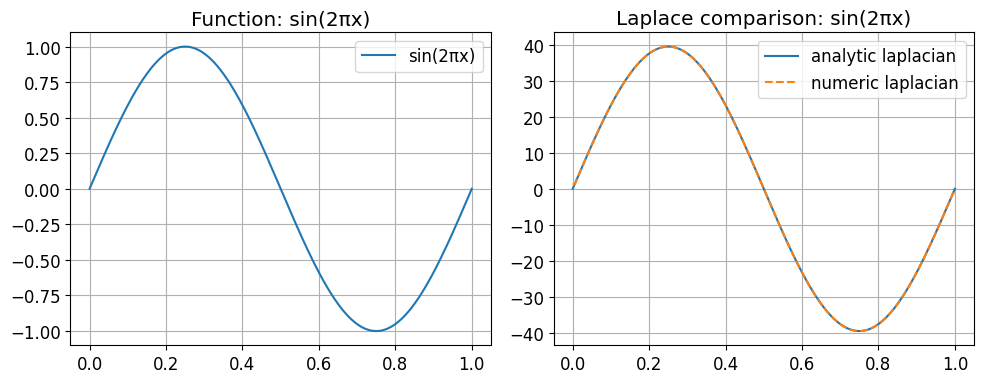

sin(2πx): max error = 1.246e+00, rms = 9.868e-02


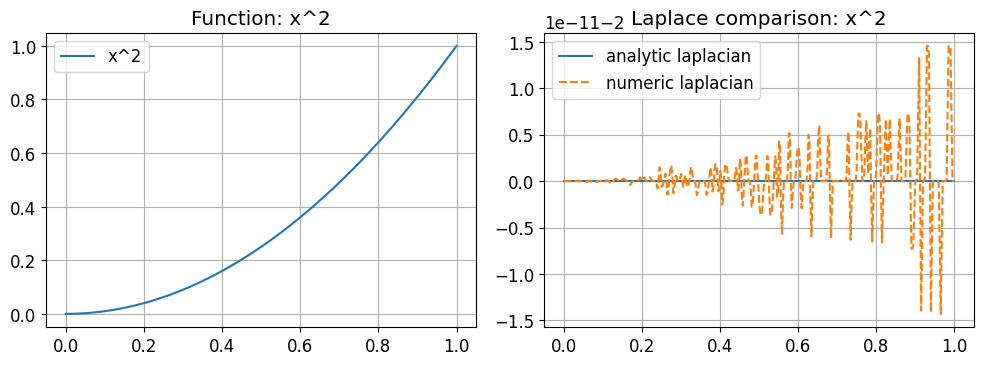

x^2: max error = 1.455e-11, rms = 3.305e-12


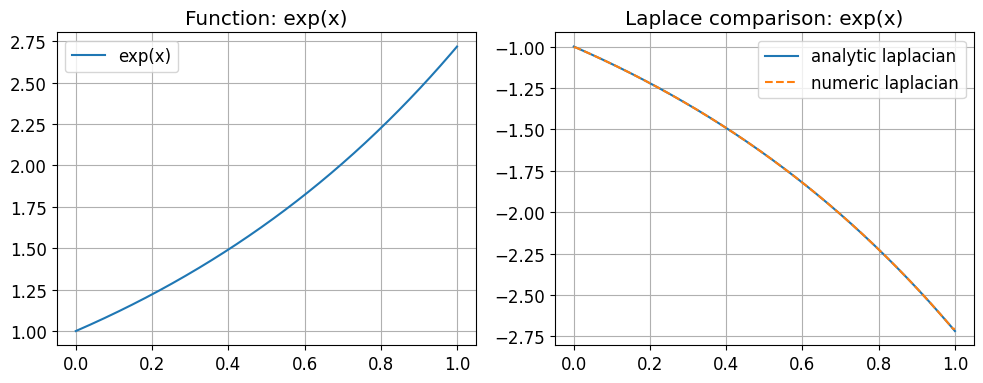

exp(x): max error = 1.362e-02, rms = 8.121e-04


In [10]:
# --- Laplacian numeric vs analytic comparisons ---
import numpy as np
import matplotlib.pyplot as plt

# simple functions and analytic laplacians (Δ = d2/dx2 on 1D)
def u1(x):
    return np.sin(2 * np.pi * x)
def lap_u1(x):
    return (2 * np.pi)**2 * np.sin(2 * np.pi * x)  # d2/dx2

def u2(x):
    return x**2
def lap_u2(x):
    return -2 * np.ones_like(np.asarray(x))

def u3(x):
    return np.exp(x)
def lap_u3(x):
    return -np.exp(x)

funcs = [(u1, lap_u1, 'sin(2πx)'), (u2, lap_u2, 'x^2'), (u3, lap_u3, 'exp(x)')]

# Ensure Laplacian operator is available
try:
    from pygeoinf.interval.operators import Laplacian
except Exception:
    raise

# grid for plotting
xs = np.linspace(0.0, 1.0, 400)

# create a default space/operator if not present in notebook
try:
    space
except NameError:
    from pygeoinf.interval.lebesgue_space import Lebesgue
    from pygeoinf.interval.interval_domain import IntervalDomain
    domain = IntervalDomain(0.0, 1.0)
    space = Lebesgue(200, domain)

bcs = BoundaryConditions('dirichlet', left=0.0, right=0.0)
lap_op = Laplacian(space, bcs, method='finite_difference', dofs=200)

from pygeoinf.interval.functions import Function

for (u_callable, lap_callable, label) in funcs:
    U = Function(space, evaluate_callable=lambda x, fun=u_callable: fun(x), name=label)
    LapU = lap_op(U)
    num_lap = LapU(xs)
    ana_lap = lap_callable(xs)

    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(xs, u_callable(xs), label=label)
    plt.title(f'Function: {label}')
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(xs, ana_lap, label='analytic laplacian')
    plt.plot(xs, num_lap, '--', label='numeric laplacian')
    plt.title(f'Laplace comparison: {label}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    diff = num_lap - ana_lap
    print(f'{label}: max error = {np.max(np.abs(diff)):.3e}, rms = {np.sqrt(np.mean(diff**2)):.3e}')